In [1]:
# not sure about colab environment, may need to install nltk, torchtext, and ???
# !pip install torchtext
!pip install nltk
!pip install portalocker

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import IMDB
import unicodedata
import re
import string
import nltk
from tqdm.autonotebook import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
from sklearn.metrics import accuracy_score
import time
# from utils import train_model
from idlmam import set_seed, LastTimeStep, train_network, Flatten, weight_reset, View, LambdaLayer

In [3]:
# configuration

# Set the theme to a dark grid with a specific palette
sns.set_theme(style="darkgrid", palette="pastel")

# Set the context for seaborn plots
sns.set_context("notebook")

torch.backends.cudnn.deterministic=True
set_seed(42)

# RNNs are SLOW on Apple Silicon, defaults to CPU for Mac
# Will choose a GPU in Colab if you're on a GPU Runtime

def get_pytorch_device(use_MPS=False):
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available() and use_MPS:
        return torch.device('mps')  # MPS is available on Apple Silicon Macs
    else:
        return torch.device('cpu')

device = get_pytorch_device()
print(device)

cuda


### Instantiate Datasets

Must remove `root=./data` from first line in textbook code.  If not, only half the training data gets loaded

In [4]:
train_iter, test_iter = IMDB(split=('train', 'test'))
train_dataset = list(train_iter)
test_dataset = list(test_iter)

## Preprocess Text and Build Vocabulary

It's pretty common to clean text data before training a model, but the exact process may vary from model to model.
Later in this notebook we'll compare the sentiment analysis results from an LSTM trained with and without cleaned data.  In this section we'll demonstrate the clearning process.

Some common things to do with text data:
* remove stop words, these are words like 'a', 'the', etc. that don't usually change the meaning of text.
* convert unicode characters to ascii
* remove punctuation and html tags
* convert all letters to lower case

In the next few cells we'll show how this can be done.

First we'll download a commonly used list of English stopwords from NLTK:


In [5]:
# Download NLTK stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) # we're going to be lazy and use this globally

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Now we'll define two functions to convert unicode to ascii and to preprocess the text:

In [6]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and (c in string.ascii_letters or c == ' ')
    )

def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    # Normalize Unicode to ASCII
    text = unicode_to_ascii(text.lower())
    # Remove all characters that are not ASCII letters, spaces or punctuation
    text = re.sub(r'[^a-z .,?!]+', ' ', text)
    # Tokenize text
    #tokens = tokenizer(text)
    tokens = text.split()
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

Here is the first review in the dataset:

In [7]:
first_review = train_dataset[0][1]
print(f'The number of characters in the first review is {len(first_review)} \n')
print(f'Here is the first review: \n\n {first_review}')

The number of characters in the first review is 1640 

Here is the first review: 

 I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was con

In [8]:
from torchtext.data.utils import get_tokenizer#tokenizers break strings like "this is a string" into lists of tokens like ['this', 'is', 'a', 'string']
tokenizer = get_tokenizer('basic_english') #we will be fine with the default english style tokenizer
first_review_preproc = preprocess_text(first_review)
first_review_preproc =' '.join(first_review_preproc)
print(f'The number of characters in the first review is {len(first_review_preproc)} \n')
print(f'Here is the first preprocessed review: \n\n {first_review_preproc}')

The number of characters in the first review is 1039 

Here is the first preprocessed review: 

 rented curiousyellow video store controversy surrounded first released also heard first seized us customs ever tried enter country therefore fan films considered controversial really see plot centered around young swedish drama student named lena wants learn everything life particular wants focus attentions making sort documentary average swede thought certain political issues vietnam war race issues united states asking politicians ordinary denizens stockholm opinions politics sex drama teacher classmates married men kills curiousyellow years ago considered pornographic really sex nudity scenes far even shot like cheaply made porno countrymen mind find shocking reality sex nudity major staple swedish cinema even ingmar bergman arguably answer good old boy john ford sex scenes films commend filmmakers fact sex shown film shown artistic purposes rather shock people make money shown pornograp

## Experiment 1 - Minimally Processed Data

This is exactly what the textbook author did.  The only text processing is whatever occurs using the tokenizer and building the vocabulary.

In [9]:
from collections import Counter #how many lines in this dataset
from torchtext.vocab import vocab #we need to create a vocabulary of all the words in the training set
from torchtext.data.utils import get_tokenizer#tokenizers break strings like "this is a string" into lists of tokens like ['this', 'is', 'a', 'string']

tokenizer = get_tokenizer('basic_english') #we will be fine with the default english style tokenizer

counter = Counter()
for (label, line) in train_dataset: #loop through the training data
    counter.update(tokenizer(line)) #count the number of unique tokens we see and how often we see them (e.g., we will see "the" a lot, but "sasquatch" mayb

vocab = vocab(counter, min_freq=10, specials=('<unk>', '<BOS>', '<EOS>', '<PAD>')) #create a vocab object, removing any word that didn't occur at least 10 times, and add special vocab items for unkown, begining of sentance, end of sentance, and "padding"

### NEW - 2024
vocab.set_default_index(vocab['<unk>'])

In [10]:
def text_transform(x): #string -> list of integers
    return [vocab['<BOS>']] + [vocab[token] for token in tokenizer(x)] + [vocab['<EOS>']] #vocab acts like a dictionary, handles unkown tokens for us, and we can make it pre and post-pend with the start and end markers respectively.

def label_transform(x):
    return x-1 #labes are originally [1, 2, 3, 4] but we need them as [0, 1, 2, 3]

# Sanity Check
print(text_transform(train_dataset[0][1]))

[1, 4, 5, 4, 6, 0, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 18, 20, 21, 22, 23, 24, 25, 4, 26, 27, 16, 28, 21, 18, 20, 29, 30, 31, 25, 32, 25, 33, 34, 18, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 12, 46, 47, 48, 4, 49, 50, 37, 51, 39, 52, 53, 25, 14, 54, 55, 56, 57, 44, 58, 59, 60, 61, 62, 63, 64, 65, 37, 66, 67, 68, 69, 70, 71, 25, 23, 72, 68, 65, 37, 73, 74, 75, 37, 76, 77, 78, 12, 79, 80, 81, 14, 82, 0, 83, 70, 84, 85, 86, 87, 88, 14, 89, 90, 91, 92, 86, 23, 14, 93, 94, 25, 23, 95, 96, 97, 91, 98, 99, 12, 0, 70, 100, 101, 80, 102, 41, 68, 103, 104, 105, 74, 60, 106, 41, 107, 41, 91, 108, 109, 25, 81, 110, 111, 70, 4, 6, 0, 55, 16, 112, 113, 114, 41, 39, 20, 47, 115, 25, 49, 41, 14, 104, 91, 116, 117, 118, 119, 91, 120, 95, 41, 121, 122, 18, 123, 32, 124, 125, 126, 77, 127, 128, 129, 25, 130, 8, 0, 131, 132, 18, 133, 41, 23, 134, 104, 91, 116, 118, 44, 135, 136, 23, 59, 137, 25, 121, 138, 139, 41, 140, 100, 141, 37, 142, 143, 144, 145, 146, 41, 50, 104, 117, 23, 147, 46, 2

In [11]:
VOCAB_SIZE = len(vocab)
NUM_CLASS = len(np.unique([z[0] for z in train_dataset]))
print("Vocab: ", VOCAB_SIZE)
print("Num Classes: ", NUM_CLASS)

padding_idx = vocab["<PAD>"]

embed_dim = 128
B = 64
epochs = 10

Vocab:  20439
Num Classes:  2


In [12]:
def pad_batch(batch):
    """
    Pad items in the batch to the length of the longest item in the batch.
    Also, re-order so that the values are returned (input, label)
    """
    labels = [label_transform(z[0]) for z in batch] #get and transform every label in the batch
    texts = [torch.tensor(text_transform(z[1]), dtype=torch.int64) for z in batch] #get, tokenizer, and put into a tensor every text
    #what is the longest sequence in this batch?
    max_len = max([text.size(0) for text in texts])
    #pad each text tensor by whatever amount gets it to the max_len
    texts = [F.pad(text, (0,max_len-text.size(0)), value=padding_idx) for text in texts]
    #make x and y a single tensor
    x, y = torch.stack(texts), torch.tensor(labels, dtype=torch.int64)

    return x, y

In [13]:
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, collate_fn=pad_batch)
test_loader = DataLoader(test_dataset, batch_size=B, collate_fn=pad_batch)

In [14]:
lstm1 = nn.Sequential(
  nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx), #(B, T) -> (B, T, D)
  nn.LSTM(embed_dim, embed_dim, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, 2*D)
  nn.Linear(embed_dim*2, NUM_CLASS), #(B, D) -> (B, classes)
)

loss_func = nn.CrossEntropyLoss()
lstm1_results = train_network(lstm1, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

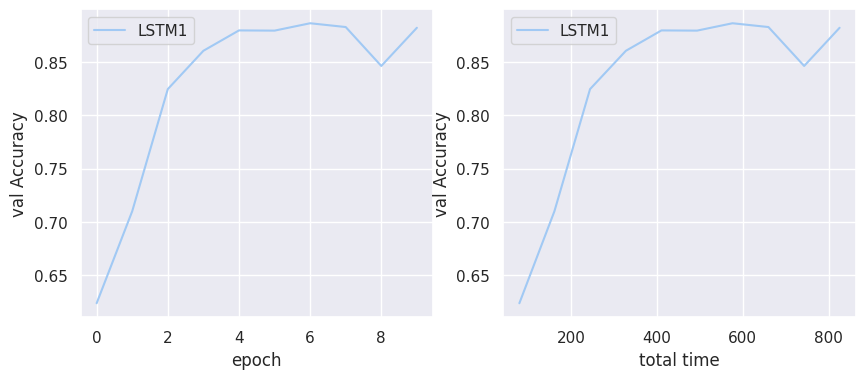

In [15]:
def make_plots(label_df_dict):
    fig,ax = plt.subplots(1,2,figsize=(10,4))
    for label,df in label_df_dict.items():
        sns.lineplot(x='epoch',y='val Accuracy',data=df,label=label,ax=ax[0]);
    for label,df in label_df_dict.items():
        sns.lineplot(x='total time',y='val Accuracy',data=df,label=label,ax=ax[1]);


results_dict = {'LSTM1':lstm1_results}
make_plots(results_dict)

## Experiment 2 - Preprocessed Reviews

Here we'll preprocess the text as shown above.  The ONLY difference in the code from Experiment 1 is that we now set `tokenizer = preprocess_text` which is defined above.

In [16]:
from collections import Counter #how many lines in this dataset
from torchtext.vocab import vocab #we need to create a vocabulary of all the words in the training set
from torchtext.data.utils import get_tokenizer#tokenizers break strings like "this is a string" into lists of tokens like ['this', 'is', 'a', 'string']

tokenizer = preprocess_text # set the tokenizer to be our function that adds additional processing

counter = Counter()
for (label, line) in train_dataset: #loop through the training data
    counter.update(tokenizer(line)) #count the number of unique tokens we see and how often we see them (e.g., we will see "the" a lot, but "sasquatch" mayb

vocab = vocab(counter, min_freq=10, specials=('<unk>', '<BOS>', '<EOS>', '<PAD>')) #create a vocab object, removing any word that didn't occur at least 10 times, and add special vocab items for unkown, begining of sentance, end of sentance, and "padding"

### NEW - 2024
vocab.set_default_index(vocab['<unk>'])

In [17]:
def text_transform(x): #string -> list of integers
    return [vocab['<BOS>']] + [vocab[token] for token in tokenizer(x)] + [vocab['<EOS>']] #vocab acts like a dictionary, handles unkown tokens for us, and we can make it pre and post-pend with the start and end markers respectively.

def label_transform(x):
    return x-1 #labes are originally [1, 2, 3, 4] but we need them as [0, 1, 2, 3]

# Sanity Check
print(text_transform(train_dataset[0][1]))

[1, 4, 0, 5, 6, 7, 8, 9, 10, 11, 12, 9, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 36, 41, 42, 43, 44, 45, 46, 0, 47, 48, 49, 50, 51, 52, 53, 50, 54, 55, 56, 57, 58, 59, 0, 60, 61, 62, 32, 63, 64, 65, 66, 67, 0, 68, 69, 23, 70, 25, 62, 71, 72, 73, 74, 75, 76, 77, 78, 79, 0, 80, 81, 82, 83, 62, 71, 84, 85, 31, 86, 74, 87, 88, 89, 90, 91, 92, 93, 94, 95, 62, 72, 22, 96, 97, 98, 62, 99, 100, 99, 101, 102, 103, 104, 105, 106, 107, 99, 70, 108, 109, 0, 91, 100, 110, 111, 112, 113, 114, 115, 116, 31, 86, 25, 100, 117, 118, 27, 2]


In [18]:
VOCAB_SIZE = len(vocab)
NUM_CLASS = len(np.unique([z[0] for z in train_dataset]))
print("Vocab: ", VOCAB_SIZE)
print("Num Classes: ", NUM_CLASS)

padding_idx = vocab["<PAD>"]

embed_dim = 128
B = 64
epochs = 10

Vocab:  20175
Num Classes:  2


In [19]:
def pad_batch(batch):
    """
    Pad items in the batch to the length of the longest item in the batch.
    Also, re-order so that the values are returned (input, label)
    """
    labels = [label_transform(z[0]) for z in batch] #get and transform every label in the batch
    texts = [torch.tensor(text_transform(z[1]), dtype=torch.int64) for z in batch] #get, tokenizer, and put into a tensor every text
    #what is the longest sequence in this batch?
    max_len = max([text.size(0) for text in texts])
    #pad each text tensor by whatever amount gets it to the max_len
    texts = [F.pad(text, (0,max_len-text.size(0)), value=padding_idx) for text in texts]
    #make x and y a single tensor
    x, y = torch.stack(texts), torch.tensor(labels, dtype=torch.int64)

    return x, y

In [20]:
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, collate_fn=pad_batch)
test_loader = DataLoader(test_dataset, batch_size=B, collate_fn=pad_batch)

In [21]:
lstm2 = nn.Sequential(
  nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx), #(B, T) -> (B, T, D)
  nn.LSTM(embed_dim, embed_dim, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, 2*D)
  nn.Linear(embed_dim*2, NUM_CLASS), #(B, D) -> (B, classes)
)

loss_func = nn.CrossEntropyLoss()
lstm2_results = train_network(lstm2, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validating:   0%|          | 0/391 [00:00<?, ?it/s]

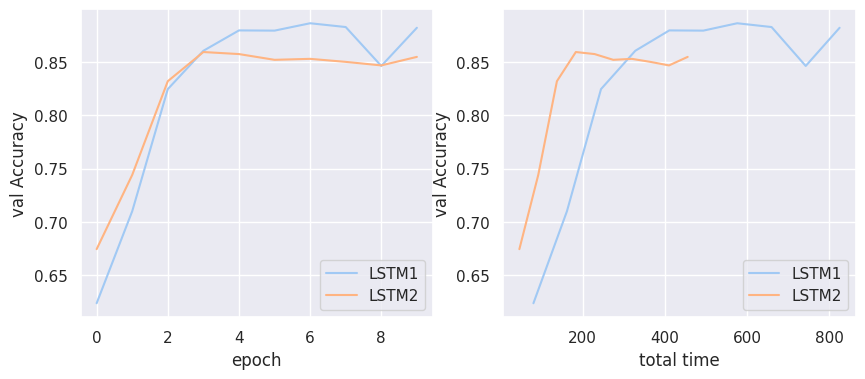

In [22]:
results_dict = {'LSTM1':lstm1_results, 'LSTM2':lstm2_results}
make_plots(results_dict)